In [1]:
pip install transformers torchaudio datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.4 MB/s eta 0:00:00


In [3]:
pip install noisereduce


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Găsite 25 fișiere .wav

=== Calcul SNR 'before' pentru toate fișierele ===


100%|██████████| 25/25 [00:00<00:00, 25.11it/s]



=== Procesare cu metoda: noisereduce ===


100%|██████████| 25/25 [04:47<00:00, 11.51s/it]



=== Procesare cu metoda: lowpass ===


100%|██████████| 25/25 [04:15<00:00, 10.23s/it]



=== Procesare cu metoda: spectralgate ===


100%|██████████| 25/25 [04:22<00:00, 10.48s/it]


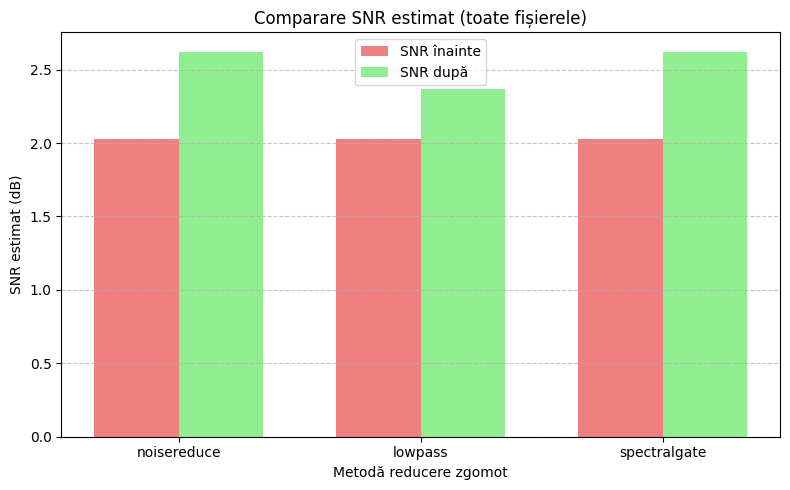

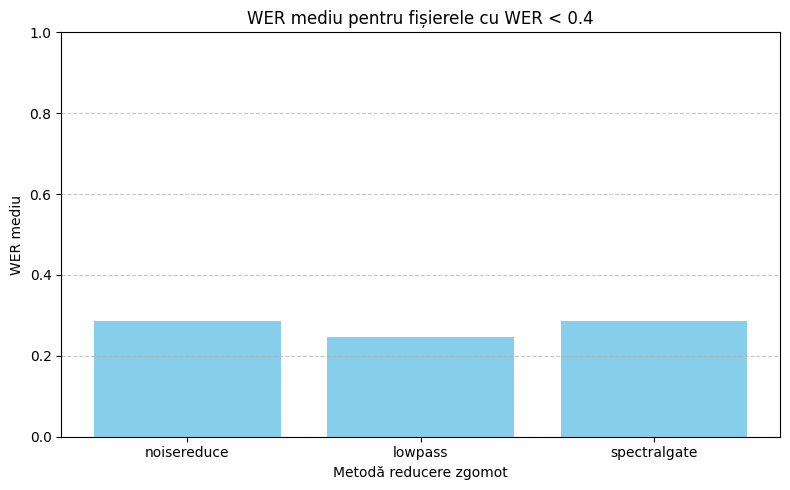

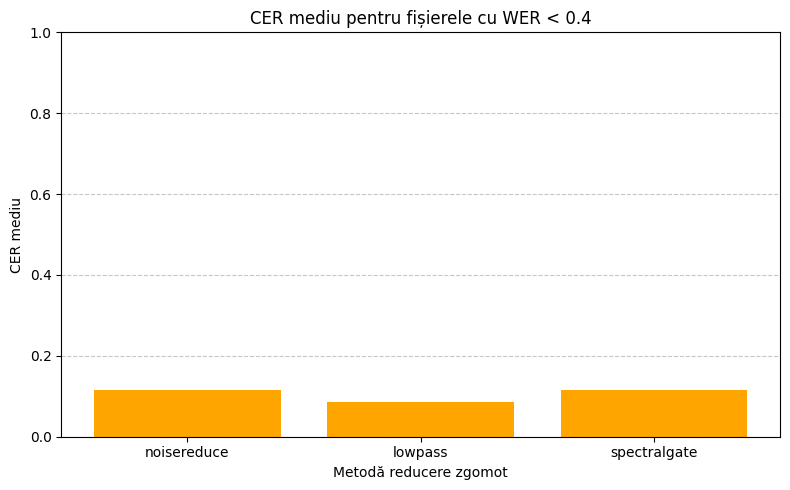

In [8]:
import os
import torch
import torchaudio
import pandas as pd
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from jiwer import wer, cer
import noisereduce as nr
import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

# Config
audio_dir = "/content/drive/MyDrive/pr/NoiseLibriSpeech/test-clean"
noise_methods = ["noisereduce", "lowpass", "spectralgate"]
wer_threshold = 0.40

# Load model & processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Low-pass filter
def apply_lowpass_filter(waveform, sr=16000, cutoff=4000, order=6):
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered = lfilter(b, a, waveform.numpy()[0])
    return torch.tensor(filtered).unsqueeze(0)

# Reducere zgomot
def reduce_noise_method(waveform, sr, method):
    if method == "noisereduce":
        return torch.tensor(nr.reduce_noise(y=waveform.numpy(), sr=sr))
    elif method == "lowpass":
        return apply_lowpass_filter(waveform, sr)
    elif method == "spectralgate":
        min_samples = int(0.5 * sr)
        if waveform.shape[1] < min_samples:
            raise ValueError(f"Fișier prea scurt pentru spectralgate: {waveform.shape[1]} samples < {min_samples}")
        noise_clip = waveform[:, :min_samples].numpy()
        return torch.tensor(nr.reduce_noise(y=waveform.numpy(), sr=sr, y_noise=noise_clip))
    else:
        raise ValueError(f"Metodă necunoscută: {method}")

# Estimare SNR
def estimate_snr_noise_clip(waveform, sr, noise_duration=0.5):
    num_noise_samples = int(noise_duration * sr)
    if waveform.shape[1] < num_noise_samples:
        return None
    noise_clip = waveform[:, :num_noise_samples]
    noise_power = torch.mean(noise_clip ** 2)
    signal_power = torch.mean(waveform ** 2)
    if noise_power == 0:
        return float('inf')
    return 10 * torch.log10(signal_power / noise_power)

# Găsire fișiere audio
audio_files = []
for root, _, files in os.walk(audio_dir):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print(f"Găsite {len(audio_files)} fișiere .wav")

# Preprocesare: waveform + SNR before
waveform_dict = {}
snr_before_dict = {}

print("\n=== Calcul SNR 'before' pentru toate fișierele ===")
for path in tqdm(audio_files):
    try:
        waveform_noisy, sample_rate = torchaudio.load(path)
        if waveform_noisy.shape[0] > 1:
            waveform_noisy = waveform_noisy.mean(dim=0, keepdim=True)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform_noisy = resampler(waveform_noisy)

        waveform_dict[path] = waveform_noisy
        snr_before = estimate_snr_noise_clip(waveform_noisy, 16000)
        snr_before_dict[path] = snr_before.item() if snr_before is not None else None

    except Exception as e:
        print(f"Eroare la preprocesare {path}: {e}")

# Procesare metode
snr_after_dict_per_method = {}
for method in noise_methods:
    print(f"\n=== Procesare cu metoda: {method} ===")
    results = []
    wer_results = []
    snr_after_dict = {}

    for path in tqdm(audio_files):
        try:
            waveform_noisy = waveform_dict[path]
            snr_before = snr_before_dict[path]

            # Filtrare zgomot
            waveform_processed = reduce_noise_method(waveform_noisy, 16000, method)
            snr_after = estimate_snr_noise_clip(waveform_processed, 16000)
            snr_after = snr_after.item() if snr_after is not None else None
            snr_after_dict[path] = snr_after

            # Transcriere
            inputs = processor(waveform_processed.squeeze(), return_tensors="pt", sampling_rate=16000).input_values
            input_values = inputs.to(device)
            with torch.no_grad():
                logits = model(input_values).logits
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = processor.decode(predicted_ids[0])

            results.append({
                "file": path,
                "transcription": transcription,
                "snr_before": snr_before,
                "snr_after": snr_after
            })

            # Evaluare WER
            txt_file = path.replace(".wav", ".trans.txt")
            if os.path.exists(txt_file):
                with open(txt_file, "r") as f:
                    ground_truth = f.read().strip()
                error_wer = wer(ground_truth.lower(), transcription.lower())
                error_cer = cer(ground_truth.lower(), transcription.lower())

                if error_wer < wer_threshold:
                    wer_results.append({
                        "file": path,
                        "model_transcription": transcription,
                        "ground_truth": ground_truth,
                        "wer": error_wer,
                        "cer": error_cer,
                        "snr_before": snr_before,
                        "snr_after": snr_after
                    })

        except Exception as e:
            print(f"Eroare la {path}: {e}")

    snr_after_dict_per_method[method] = snr_after_dict
    pd.DataFrame(results).to_csv(f"transcrieri_{method}.csv", index=False)
    pd.DataFrame(wer_results).to_csv(f"wer_results_{method}.csv", index=False)

# Calcul metrici finale
wer_mediu_per_metoda = {}
cer_mediu_per_metoda = {}
snr_before_mediu_per_metoda = {}
snr_after_mediu_per_metoda = {}

for method in noise_methods:
    try:
        df_snr = pd.read_csv(f"transcrieri_{method}.csv")
        snr_before_mediu_per_metoda[method] = df_snr['snr_before'].mean()
        snr_after_mediu_per_metoda[method] = df_snr['snr_after'].mean()

        df_wer = pd.read_csv(f"wer_results_{method}.csv")
        if not df_wer.empty:
            wer_mediu_per_metoda[method] = df_wer['wer'].mean()
            cer_mediu_per_metoda[method] = df_wer['cer'].mean()
        else:
            wer_mediu_per_metoda[method] = None
            cer_mediu_per_metoda[method] = None
    except Exception as e:
        print(f"Eroare la metrici pentru {method}: {e}")

# Plot SNR (toate fișierele)
methods = list(noise_methods)
snr_before_values = [snr_before_mediu_per_metoda[m] if snr_before_mediu_per_metoda[m] is not None else 0 for m in methods]
snr_after_values = [snr_after_mediu_per_metoda[m] if snr_after_mediu_per_metoda[m] is not None else 0 for m in methods]

plt.figure(figsize=(8,5))
bar_width = 0.35
x = np.arange(len(methods))
plt.bar(x, snr_before_values, bar_width, label='SNR înainte', color='lightcoral')
plt.bar(x + bar_width, snr_after_values, bar_width, label='SNR după', color='lightgreen')
plt.xlabel("Metodă reducere zgomot")
plt.ylabel("SNR estimat (dB)")
plt.title("Comparare SNR estimat (toate fișierele)")
plt.xticks(x + bar_width / 2, methods)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("comparatie_snr_before_after.png")
plt.show()

# Plot WER
wer_values = [wer_mediu_per_metoda[m] if wer_mediu_per_metoda[m] is not None else 0 for m in methods]
plt.figure(figsize=(8,5))
plt.bar(methods, wer_values, color='skyblue')
plt.xlabel("Metodă reducere zgomot")
plt.ylabel("WER mediu")
plt.title("WER mediu pentru fișierele cu WER < 0.4")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("comparatie_wer_metode_filtrat.png")
plt.show()

# Plot CER
cer_values = [cer_mediu_per_metoda[m] if cer_mediu_per_metoda[m] is not None else 0 for m in methods]
plt.figure(figsize=(8,5))
plt.bar(methods, cer_values, color='orange')
plt.xlabel("Metodă reducere zgomot")
plt.ylabel("CER mediu")
plt.title("CER mediu pentru fișierele cu WER < 0.4")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("comparatie_cer_metode_filtrat.png")
plt.show()
